# ReAct(Reasoning + Acting)

In [4]:
import os
from langchain.agents import create_agent
from langchain_community.tools import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage
from langgraph.graph.message import add_messages


# Create retrieval tool

In [5]:
docs = WebBaseLoader("https://publications.anveshanaindia.com/wp-content/uploads/2022/10/A-STUDY-ON-CRICKET-TEAM-SELECTION-UTILIZING-SOME-TECHNIQUES.pdf").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks,embedding)
retriver = vectorstore.as_retriever()

In [6]:
retriver

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x120401be0>, search_kwargs={})

In [7]:
retriver.invoke("what is No of Innings")

[Document(id='01ef9a9f-5a07-445d-a147-6f6256de2409', metadata={'source': 'https://publications.anveshanaindia.com/wp-content/uploads/2022/10/A-STUDY-ON-CRICKET-TEAM-SELECTION-UTILIZING-SOME-TECHNIQUES.pdf'}, page_content='�\x03s\x0e�<���I��:�ܚ�ǩ�\x03���H�\x00Eo3\x00y�\x12y-��1�\x1a�[O��D�\x08o9a0��6�\r��"�`g8\x19�}-�7����ꚝ��\x1a}��e����#\x1a�C\x03�\x06\x19\x19�\x04&�U�\x0ev�\x0785Pjڿ�]��z���}��ѽ�J�2�\x12��.NU�w\x13�+�`\x0fM'),
 Document(id='5a10e4a2-5ed3-4aae-b71a-f9fa1da77d4e', metadata={'source': 'https://publications.anveshanaindia.com/wp-content/uploads/2022/10/A-STUDY-ON-CRICKET-TEAM-SELECTION-UTILIZING-SOME-TECHNIQUES.pdf'}, page_content='N���R�/ �GY�>̘2O �A{\x1c?�0�=D.+�JbnB>\t�\x05����mH;!l���wʊ����p�Sf7r\x12�\x11,%�3D�\x15���\x1b�UH\x07\'���}\x0e\x03��\x1c\x18��?�|\x0e�p����"İ�z�\x04���\x06�\x00�\x07n"����g\x0f�y\x0f-��_\x0f�O2��0c�b.e�\x1f�<����3<\x03(>� p"�\x06�6���6+�\x13V1�(~�����T�;��\\G�F��=��\x0c/�\\�\x05�--\uf39b�\x1at����\r�\'z��a��1~\x1d=���*\x1f�����;Zg6�\x17m/�7tǼ\

In [8]:
def retriver_tool_func(query: str) -> str:
    print("Using RAGRetriever tool")
    docs = retriver.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [9]:
retriver_tool_func("what is No of Innings")

Using RAGRetriever tool


'�\x03s\x0e�<���I��:�ܚ�ǩ�\x03���H�\x00Eo3\x00y�\x12y-��1�\x1a�[O��D�\x08o9a0��6�\r��"�`g8\x19�}-�7����ꚝ��\x1a}��e����#\x1a�C\x03�\x06\x19\x19�\x04&�U�\x0ev�\x0785Pjڿ�]��z���}��ѽ�J�2�\x12��.NU�w\x13�+�`\x0fM\nN���R�/ �GY�>̘2O �A{\x1c?�0�=D.+�JbnB>\t�\x05����mH;!l���wʊ����p�Sf7r\x12�\x11,%�3D�\x15���\x1b�UH\x07\'���}\x0e\x03��\x1c\x18��?�|\x0e�p����"İ�z�\x04���\x06�\x00�\x07n"����g\x0f�y\x0f-��_\x0f�O2��0c�b.e�\x1f�<����3<\x03(>� p"�\x06�6���6+�\x13V1�(~�����T�;��\\G�F��=��\x0c/�\\�\x05�--\uf39b�\x1at����\r�\'z��a��1~\x1d=���*\x1f�����;Zg6�\x17m/�7tǼ\x17���\x1efs\n�*\x07\\��5-6\x1dWN���\x0f�N�\x1b�;H�p}sϧ�j=/IM1��\x13\\\\\\0if�n���\x18UU\x18\x1e��Pz�\x0e�5խ��"�̚�I4\x12\x02I�+��g��\x15�=\\�\x0f��lS��\x16׳!6�k$\x07��*�v�w\x02�@\x1dP�\x0f��q^��I�g-��10�\x1e9\x00c���(\x03���(\x00��(\x00��(\x00��(\x00�Z��\x1a����!xd��\x0cT�A\x04\x10A\x04\x10\x0eA�Wh�\x0cO�E4��j\x1f�2��\x00���\x00�SL����\x00�+��.��\x0cO�E4��j\x1f�2��\x00���\x00�SL����\x00�+��.��\x0cO�E4��j\x1f�2��\x00���\x00�SL����\x00�+��.��\

In [10]:
retriver_tool=Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant info",
    func=retriver_tool_func
)
retriver_tool

Tool(name='RAGRetriever', description='Use this tool to fetch relevant info', func=<function retriver_tool_func at 0x12613b380>)

# Wikipedia tool

In [11]:
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/jaspalsingh/Desktop/agentic-rag/.venv/lib/python3.13/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [12]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

# Define Agent Node

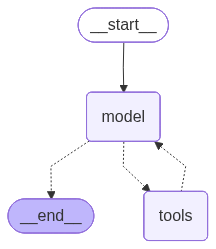

In [13]:
tools = [retriver_tool,wiki_tool]

react_node = create_agent(llm,tools)

react_node

# Langgraph agent state

In [14]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

# Build Langgraph graph

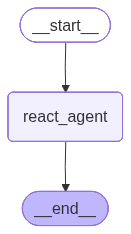

In [16]:
builder = StateGraph(AgentState)

builder.add_node("react_agent",react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent",END)

graph = builder.compile()

graph

In [18]:
if __name__ == "__main__":
    user_query = "What is the formula for calculating Batting Average? and also tell me what does wikipedia tell me about it"
    state = {"messages":[HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n Final Answer:\n",result['messages'][-1].content)

Using RAGRetriever tool

 Final Answer:
 The formula for calculating the Batting Average in cricket is:

**Batting Average** = Total runs scored / Number of times out

This metric is commonly used to gauge a cricket player's skill as a batter, as it reflects the average number of runs they score per innings when they get out.

### Wikipedia Summary on Batting Average:

#### Cricket
In cricket, a player's batting average is the total number of runs they have scored divided by the number of times they have been out. It is usually given to two decimal places and considered a good measure of a player's skill as a batter. Each player may have several batting averages, with different figures calculated for different types of matches (first-class, one-day, Test matches, etc.), seasons, series, or against particular opponents.

#### Baseball
In baseball, the batting average (BA) is determined by dividing a player's hits by their total at-bats, usually rounded to three decimal places. A player 

# More tools

In [20]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain_community.tools import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader,ArxivLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import create_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.graph.message import add_messages

In [21]:
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x120403620>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1202a01a0>, root_client=<openai.OpenAI object at 0x124cead50>, root_async_client=<openai.AsyncOpenAI object at 0x124ceb4d0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

# Generic function to create retrieval tool

In [23]:
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50).split_documents(docs)
    vs=FAISS.from_documents(chunks,OpenAIEmbeddings())
    retriver=vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"Using Tool:{name}")
        results=retriver.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)

# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# ArXiv Tool
def arxiv_search(query: str) -> str:
    print("Searching ArXiv...")
    results=ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name="ArxivSearch",
    description="fetch recent academic papers",
    func=arxiv_search
)

In [26]:
internal_tool_1=make_retriever_tool_from_text(
    "example.txt",
    "InternalTechDocs",
    "Search internal tech documents from example"
)
internal_tool_1

Tool(name='InternalTechDocs', description='Search internal tech documents from example', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x121bd6d40>)

In [27]:
internal_tool_2=make_retriever_tool_from_text(
    "example2.txt",
    "InternalTechDocs2",
    "Search dummy details from example2"
)
internal_tool_2

Tool(name='InternalTechDocs2', description='Search dummy details from example2', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x121bd79c0>)

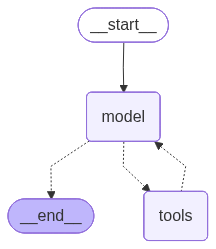

In [28]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node=create_agent(llm,tools)
react_node

In [29]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

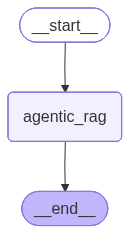

In [30]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag",react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag",END)

graph=builder.compile()
graph

In [33]:
query="what does example say and what does arxiv suggest recently?"
state={"messages":[HumanMessage(content=query)]}
result=graph.invoke(state)

print("Final Answer:\n",result["messages"][-1].content)

Using Tool:InternalTechDocsSearching ArXiv...

Final Answer:
 Here's the information retrieved from Example and Arxiv:

### Example Document (InternalTechDocs)
- **Content**: 
  - Mentions of John Doe related to anonymous parties in legal contexts.
  - The use of "John Doe" originates from the UK, with UK alternatives like "Joe Bloggs" or "John Smith."
  
### Recent Academic Papers (Arxiv)
1. **Title**: A Systematic Literature Review on Technology Acceptance Research on Augmented Reality in the Field of Training and Education
   - **Authors**: Stefan Graser, Stephan Böhm
   - **Summary**: Discusses the user acceptance of augmented reality (AR) in training and education, summarizing various research models developed over the years to answer related questions.
   
2. **Title**: Innovative Technologies for Optical and Infrared Astronomy
   - **Authors**: Colin R. Cunningham, Christopher J. Evans, Frank Molster, Sarah Kendrew, Matthew A. Kenworthy, Frans Snik
   - **Summary**: Explores how